## SIMULAÇÃO LINHA ATUAL 

IMPORTS

In [163]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [164]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)
    
    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



In [165]:
get_process_times_from_csv("Yamazumi - Accelo.csv")

{'ARREFEC': 316,
 'DIESEL': 253,
 'REAPERTO': 235,
 'ESTEPE': 290,
 'PNEU_LD': 250,
 'PNEU_LE': 250,
 'APERTO_LD': 304,
 'APERTO_LE': 304,
 'GRADE': 270,
 'MECACNICA_1': 194,
 'MECACNICA_2': 194,
 'ELACTRICA_1': 357,
 'ELACTRICA_2': 357,
 'CONTROLE': 265,
 'MOTORISTA': 266,
 'QUIS': 270}

### ETAPA 02: Criando dicionário de tempos por posto

##### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




##### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [166]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 1, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1}
              }


In [167]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    """
    Gera o dicionário POSTOS por modelo com tempos por posto a partir das regras fixas por perna.
    - Respeita MODELOS_CSV['perna'] como lista (ex.: [1] ou [1,2]).
    - Se um modelo tiver mais de uma perna, cria chaves separadas, e.g. "Atego (ATP) P1" e "Atego (ATP) P2".
    - Em cada perna, aplica exatamente as fórmulas descritas pelo usuário, dividindo sempre por 'operadores'
      antes de combinar (somar, fazer médias e dividir pelos fatores).
    - Campo 'perna' no POSTOS sai como lista, ex.: {"tempo_tot": ..., "perna": [1]}.
    """

    # Ordem de exibição dos postos
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']

    POSTOS = {}

    # Helpers ----------------------------
    def _coerce_pernas(pernas):
        """Garante que 'perna' venha como lista."""
        if isinstance(pernas, int):
            return [pernas]
        if isinstance(pernas, (list, tuple)):
            return list(pernas)
        # fallback (caso venha outro iterável)
        return list(pernas)

    def t(atividade, tempos, ativ_dict):
        """Tempo da atividade já dividido pelo nº de operadores (se existir)."""
        if atividade not in ativ_dict:
            return 0.0
        ops = ativ_dict[atividade].get('operadores', 1) or 1
        return (tempos.get(atividade, 0.0)) / ops

    def avg(vals):
        vals = [v for v in vals if v is not None]
        return (sum(vals) / len(vals)) if vals else 0.0

    # ------------------------------------

    for modelo, dados_modelo in MODELOS_CSV.items():
        pernas_modelo = _coerce_pernas(dados_modelo.get("perna", []))
        arquivo = dados_modelo["tempos"]

        # tempos por atividade vindo do Yamazumi
        tempos_atividade = get_process_times_from_csv(arquivo)
        if not tempos_atividade:
            # Se não conseguiu ler tempos, só pula o modelo
            continue

        for perna_atual in pernas_modelo:
            if perna_atual == 1:
                ativ = ATIVIDADES_P1
                ordem = ordem_P1

                # --------- Regras PERNA 1 ---------
                # 30A --> DIESEL/num operadores
                p_30A = t('DIESEL', tempos_atividade, ativ)

                # 31A --> ARREFEC/num operadores
                p_31A = t('ARREFEC', tempos_atividade, ativ)

                # 32A --> REAPERTO/op + (EL1/op + EL2/op)/2/3
                el_mix_p1 = avg([t('ELACTRICA_1', tempos_atividade, ativ),
                                 t('ELACTRICA_2', tempos_atividade, ativ)]) / 3.0
                p_32A = t('REAPERTO', tempos_atividade, ativ) + el_mix_p1

                # 32C --> ESTEPE/op + APERTO_LE/op + 5AA_RODA/op + (EL1/op + EL2/op)/2/3
                p_32C = (
                    t('ESTEPE', tempos_atividade, ativ) +
                    avg([t('APERTO_LE', tempos_atividade, ativ), t('5AA_RODA', tempos_atividade, ativ)]) +
                    el_mix_p1
                )

                # 33A --> (PNEU_LE/op + PNEU_LD/op)/2 + (EL1/op + EL2/op)/2/3
                pneus_p1 = avg([t('PNEU_LE', tempos_atividade, ativ),
                                t('PNEU_LD', tempos_atividade, ativ)])
                p_33A = pneus_p1 + el_mix_p1

                # 34A --> APERTO_LD/op + GRADE/op + (MEC1/op + MEC2/op)/2/2
                mec_avg_p1 = avg([t('MECACNICA_1', tempos_atividade, ativ),
                                  t('MECACNICA_2', tempos_atividade, ativ)]) / 2.0
                p_34A = t('APERTO_LD', tempos_atividade, ativ) + t('GRADE', tempos_atividade, ativ) + mec_avg_p1

                # 38 --> MOTORISTA/op + QUIS/op + (MEC1/op + MEC2/op)/2/2
                p_38 = t('MOTORISTA', tempos_atividade, ativ) + t('QUIS', tempos_atividade, ativ) + mec_avg_p1

                tempos_por_posto = {
                    '30A': p_30A,
                    '31A': p_31A,
                    '32A': p_32A,
                    '32C': p_32C,
                    '33A': p_33A,
                    '34A': p_34A,
                    '38' : p_38
                }

            elif perna_atual == 2:
                ativ = ATIVIDADES_P2
                ordem = ordem_P2

                # --------- Regras PERNA 2 ---------
                # 30B --> PASSADISASSO/op
                p_30B = t('PASSADISASSO', tempos_atividade, ativ)

                # 31B --> ABASTECIMENTO/op
                p_31B = t('ABASTECIMENTO', tempos_atividade, ativ)

                # 32B --> CHINELEIRA/op
                p_32B = t('CHINELEIRA', tempos_atividade, ativ)

                # 32D --> 5AA_RODA/op
                p_32D = t('5AA_RODA', tempos_atividade, ativ)

                # Elétrica (I+II+III): ((EL_I/op + EL_II/op + EL_III/op)/2)/3
                el_sum = sum([
                    t('ELACTRICA_I', tempos_atividade, ativ),
                    t('ELACTRICA_II', tempos_atividade, ativ),
                    t('ELACTRICA_III', tempos_atividade, ativ)
                ])
                el_share = (el_sum / 2.0) / 3.0

                # 33B --> (PNEU_LE/op + PNEU_LD/op)/2 + el_share
                pneus_p2 = avg([t('PNEU_LE', tempos_atividade, ativ),
                                t('PNEU_LD', tempos_atividade, ativ)])
                p_33B = pneus_p2 + el_share

                # 34B --> ((PARALAMA_LD+PARALAMA_LE)/2 + CONTROLE/op + el_share)
                paralamas_avg = avg([t('PARALAMA_LD', tempos_atividade, ativ),
                                     t('PARALAMA_LE', tempos_atividade, ativ)])
                p_34B = paralamas_avg + t('CONTROLE', tempos_atividade, ativ) + el_share

                # 39 --> el_share
                p_39 = el_share

                tempos_por_posto = {
                    '30B': p_30B,
                    '31B': p_31B,
                    '32B': p_32B,
                    '32D': p_32D,
                    '33B': p_33B,
                    '34B': p_34B,
                    '39' : p_39
                }

            else:
                # perna inválida (só 1 e 2 são suportadas)
                continue

            # Monta o dicionário de saída do modelo nessa perna
            postos_ordenados = {}
            for posto in ordem:
                if posto in tempos_por_posto and tempos_por_posto[posto] > 0:
                    postos_ordenados[posto] = {"tempo_tot": tempos_por_posto[posto], "perna": [perna_atual]}

            # Se o modelo tem mais de uma perna, cria nomes distintos
            chave_modelo = modelo if len(pernas_modelo) == 1 else f"{modelo} P{perna_atual}"
            POSTOS[chave_modelo] = postos_ordenados

    return POSTOS


In [168]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'APERTO':    {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"},
#         },
#         'P2': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'PARALAMA':  {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'], "agreg": "media"},
#         }
#     }

#     # Para contagem (opcional) de operadores ao final
#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     # Atividades de P2 que entram nas fórmulas e NÃO podem ser duplicadas depois
#     ESPECIAIS_P2_ATIVS = {
#         "PNEU_LD", "PNEU_LE",
#         "PARALAMA_LD", "PARALAMA_LE",
#         "CONTROLE",
#         "ELACTRICA_I", "ELACTRICA_II", "ELACTRICA_III"
#     }

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         pernas_modelo = dados_modelo.get("perna", [])
#         if isinstance(pernas_modelo, int):
#             pernas_modelo = [pernas_modelo]
#         elif not isinstance(pernas_modelo, (list, tuple)):
#             pernas_modelo = list(pernas_modelo)

#         # Carrega tempos Yamazumi -> {atividade: segundos}
#         tempos_atividade = get_process_times_from_csv(dados_modelo["tempos"])
#         if not tempos_atividade:
#             continue

#         for perna_atual in pernas_modelo:
#             atividades_dict = ATIVIDADES_P1 if perna_atual == 1 else ATIVIDADES_P2
#             ordem_postos = ordem_P1 if perna_atual == 1 else ordem_P2
#             grupos = GRUPOS_ESPECIAIS['P1'] if perna_atual == 1 else GRUPOS_ESPECIAIS['P2']

#             dicionario_postos = {}
#             atividades_processadas = set()  # tudo que já foi computado (para não duplicar)

#             # -------------------------
#             # REGRAS EXATAS DA PERNA 2
#             # -------------------------
#             if perna_atual == 2:
#                 el_i   = tempos_atividade.get("ELACTRICA_I", 0.0)
#                 el_ii  = tempos_atividade.get("ELACTRICA_II", 0.0)
#                 el_iii = tempos_atividade.get("ELACTRICA_III", 0.0)
#                 eletrica_por_posto = ((el_i + el_ii + el_iii) / 2.0) / 3.0  # ((EL_I+EL_II+EL_III)/2)/3

#                 # 33B
#                 pneu_ld = tempos_atividade.get("PNEU_LD", 0.0)
#                 pneu_le = tempos_atividade.get("PNEU_LE", 0.0)
#                 tempo_33B = (pneu_ld + pneu_le) / 2.0 + eletrica_por_posto
#                 if "33B" in ordem_postos:
#                     dicionario_postos["33B"] = {"tempo_tot": tempo_33B, "perna": [2]}

#                 # 34B
#                 paralama_ld = tempos_atividade.get("PARALAMA_LD", 0.0)
#                 paralama_le = tempos_atividade.get("PARALAMA_LE", 0.0)
#                 controle    = tempos_atividade.get("CONTROLE", 0.0)
#                 tempo_34B = (paralama_ld + paralama_le) / 2.0 + controle + eletrica_por_posto
#                 if "34B" in ordem_postos:
#                     dicionario_postos["34B"] = {"tempo_tot": tempo_34B, "perna": [2]}

#                 # 39
#                 if "39" in ordem_postos:
#                     dicionario_postos["39"] = {"tempo_tot": eletrica_por_posto, "perna": [2]}

#                 # Marcar como já processadas
#                 atividades_processadas.update(ESPECIAIS_P2_ATIVS)
#                 atividades_unicas_por_perna[2].update(ESPECIAIS_P2_ATIVS)

#             # -------------------------------------
#             # GRUPOS ESPECIAIS (P1 e também P2, se não colidir com as fórmulas)
#             # -------------------------------------
#             for _, grupo in grupos.items():
#                 atvs = grupo["atividades"]

#                 # Na P2, se tocar em alguma atividade já processada na fórmula, pula
#                 if perna_atual == 2 and any(a in atividades_processadas for a in atvs):
#                     continue

#                 if not all(a in tempos_atividade and a in atividades_dict for a in atvs):
#                     continue

#                 for a in atvs:
#                     atividades_unicas_por_perna[perna_atual].add(a)

#                 if grupo["agreg"] == "media":
#                     soma = 0.0
#                     for a in atvs:
#                         ops = atividades_dict[a]['operadores'] or 1
#                         soma += tempos_atividade[a] / ops
#                     tempo = soma / len(atvs)

#                 elif grupo["agreg"] == "paralama":
#                     soma_tempos = sum(tempos_atividade[a] for a in atvs)
#                     soma_ops = (sum(atividades_dict[a]['operadores'] for a in atvs) / 2.0) or 1.0
#                     tempo = soma_tempos / soma_ops

#                 else:
#                     continue

#                 postos_grupo = set(p for a in atvs for p in atividades_dict[a]['postos'])
#                 if not postos_grupo:
#                     continue
#                 tempo_por_posto = tempo / len(postos_grupo)

#                 for posto in postos_grupo:
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0.0, "perna": [perna_atual]})
#                     dicionario_postos[posto]["tempo_tot"] += tempo_por_posto
#                     # garantir lista sem duplicata
#                     dicionario_postos[posto]["perna"] = list({*dicionario_postos[posto]["perna"], perna_atual})

#                 atividades_processadas.update(atvs)

#             # -------------------------------------
#             # ATIVIDADES INDIVIDUAIS (não especiais, não em grupo)
#             # -------------------------------------
#             for atividade, props in atividades_dict.items():
#                 if atividade in atividades_processadas:
#                     continue
#                 if modelo not in props.get('modelos', []):
#                     continue
#                 if atividade not in tempos_atividade:
#                     continue

#                 atividades_unicas_por_perna[perna_atual].add(atividade)

#                 ops = props.get('operadores', 1) or 1
#                 tempo = tempos_atividade[atividade] / ops

#                 for posto in props.get('postos', []):
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0.0, "perna": [perna_atual]})
#                     dicionario_postos[posto]["tempo_tot"] += tempo
#                     dicionario_postos[posto]["perna"] = list({*dicionario_postos[posto]["perna"], perna_atual})

#             # Ordena por ordem de posto da perna
#             postos_ordenados = {}
#             for p in ordem_postos:
#                 if p in dicionario_postos:
#                     postos_ordenados[p] = dicionario_postos[p]

#             # Se tem mais de uma perna, cria chave “Modelo P<perna>”
#             chave_modelo = modelo if len(pernas_modelo) == 1 else f"{modelo} P{perna_atual}"
#             POSTOS[chave_modelo] = postos_ordenados

#     # (Opcional) contagem de operadores por perna
#     operadores = {1: 0, 2: 0}
#     for p in [1, 2]:
#         atividades = atividades_unicas_por_perna[p]
#         atividades_dict = ATIVIDADES_P1 if p == 1 else ATIVIDADES_P2
#         for a in atividades:
#             if a in atividades_dict:
#                 operadores[p] += atividades_dict[a]["operadores"]

#     print("\n👷‍♂️ Operadores totais por perna:")
#     for p in [1, 2]:
#         print(f"  Perna {p}: {operadores[p]} operadores")

#     return POSTOS, operadores


In [169]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     # atividades especiais que entram nas regras fixas da P2 (para evitar dupla contagem)
#     ESPECIAIS_P2 = {
#         "grupo_pneu": {"atividades": ["PNEU_LD", "PNEU_LE"], "postos": ["33B"]},
#         "grupo_paralama": {"atividades": ["PARALAMA_LD", "PARALAMA_LE"], "postos": ["34B"]},
#         "grupo_controle": {"atividades": ["CONTROLE"], "postos": ["34B"]},
#         "grupo_eletrica": {"atividades": ["ELACTRICA_I", "ELACTRICA_II", "ELACTRICA_III"], "postos": ["33B", "34B", "39"]},
#     }
#     ATVS_P2_ESPECIAIS = set().union(*[set(g["atividades"]) for g in ESPECIAIS_P2.values()])

#     for modelo, dados in MODELOS_CSV.items():
#         # suporta perna ser int ou lista
#         pernas_modelo = dados["perna"] if isinstance(dados["perna"], (list, tuple)) else [dados["perna"]]
#         tempos_atividade = get_process_times_from_csv(dados["tempos"])
#         if not tempos_atividade:
#             POSTOS[modelo] = {}
#             continue

#         for perna_atual in pernas_modelo:
#             atividades_dict = ATIVIDADES_P1 if perna_atual == 1 else ATIVIDADES_P2
#             ordem_postos = ordem_P1 if perna_atual == 1 else ordem_P2

#             dicionario_postos = {}

#             if perna_atual == 2:
#                 # --- Regras especiais P2 (usando tempos puros do Yamazumi) ---

#                 # PNEUS (33B): média dos dois -> (LD+LE)/2
#                 pneu_ld = tempos_atividade.get("PNEU_LD", 0.0)
#                 pneu_le = tempos_atividade.get("PNEU_LE", 0.0)
#                 tempo_pneu_33B = (pneu_ld + pneu_le) / 2.0

#                 # ELÉTRICA: (I+II+III)/2 por compartilhamento de operadores, depois /3 por dividir 33B/34B/39
#                 el_i = tempos_atividade.get("ELACTRICA_I", 0.0)
#                 el_ii = tempos_atividade.get("ELACTRICA_II", 0.0)
#                 el_iii = tempos_atividade.get("ELACTRICA_III", 0.0)
#                 eletrica_compartilhada = (el_i + el_ii + el_iii) / 2.0
#                 eletrica_por_posto = eletrica_compartilhada / 3.0

#                 # 33B: pneus + elétrica_por_posto
#                 if "33B" in ordem_postos:
#                     dicionario_postos["33B"] = {"tempo_tot": tempo_pneu_33B + eletrica_por_posto, "perna": [2]}

#                 # 34B: (paralama_ld+paralama_le)/2 + CONTROLE + elétrica_por_posto
#                 paralama_ld = tempos_atividade.get("PARALAMA_LD", 0.0)
#                 paralama_le = tempos_atividade.get("PARALAMA_LE", 0.0)
#                 tempo_paralama = (paralama_ld + paralama_le) / 2.0
#                 tempo_controle = tempos_atividade.get("CONTROLE", 0.0)

#                 if "34B" in ordem_postos:
#                     dicionario_postos["34B"] = {
#                         "tempo_tot": tempo_paralama + tempo_controle + eletrica_por_posto,
#                         "perna": [2],
#                     }

#                 # 39: somente elétrica_por_posto
#                 if "39" in ordem_postos:
#                     dicionario_postos["39"] = {"tempo_tot": eletrica_por_posto, "perna": [2]}

#             # --- Loop genérico (demais atividades, com divisão por operadores) ---
#             for atividade, props in atividades_dict.items():
#                 # filtra por modelo
#                 if modelo not in props.get("modelos", []):
#                     continue
#                 # precisa existir tempo
#                 if atividade not in tempos_atividade:
#                     continue
#                 # se for perna 2, não duplique as especiais (já tratadas nas fórmulas)
#                 if perna_atual == 2 and atividade in ATVS_P2_ESPECIAIS:
#                     continue

#                 tempo_bruto = tempos_atividade[atividade]
#                 ops = props.get("operadores", 1) or 1
#                 tempo_por_op = tempo_bruto / ops

#                 for posto in props.get("postos", []):
#                     # Se o posto já foi setado pelas regras especiais, apenas some (desde que
#                     # não seja uma atividade especial — o filtro acima já evita isso).
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0.0, "perna": [perna_atual]})
#                     # garanta que a chave perna é lista
#                     if "perna" in dicionario_postos[posto]:
#                         # unifica lista de pernas
#                         pernas_exist = set(dicionario_postos[posto]["perna"])
#                         pernas_exist.add(perna_atual)
#                         dicionario_postos[posto]["perna"] = sorted(pernas_exist)
#                     dicionario_postos[posto]["tempo_tot"] += tempo_por_op

#             # ordena saída
#             postos_ordenados = {}
#             for p in ordem_postos:
#                 if p in dicionario_postos:
#                     postos_ordenados[p] = dicionario_postos[p]

#             # Se o modelo passa por mais de uma perna, você pode optar por separar por sufixo
#             # ou unificar no mesmo nome. Aqui vou unificar no mesmo nome, somando/mesclando.
#             if modelo not in POSTOS:
#                 POSTOS[modelo] = {}
#             # merge (se já existir por conta de outra perna do mesmo modelo)
#             for p, info in postos_ordenados.items():
#                 if p not in POSTOS[modelo]:
#                     POSTOS[modelo][p] = info
#                 else:
#                     # soma tempo e merge de pernas
#                     POSTOS[modelo][p]["tempo_tot"] += info["tempo_tot"]
#                     pernas_exist = set(POSTOS[modelo][p]["perna"])
#                     pernas_exist.update(info["perna"])
#                     POSTOS[modelo][p]["perna"] = sorted(pernas_exist)

#     return POSTOS


In [170]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'APERTO':    {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"},
#         },
#         'P2': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'PARALAMA':  {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'], "agreg": "media"},
#         }
#     }

#     # Para eventual contagem de operadores ao final
#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         # --- COERÇÃO: perna sempre como lista ---
#         pernas_modelo = dados_modelo.get("perna", [])
#         if isinstance(pernas_modelo, int):
#             pernas_modelo = [pernas_modelo]
#         elif not isinstance(pernas_modelo, (list, tuple)):
#             pernas_modelo = list(pernas_modelo)

#         # carrega tempos do CSV (dicionário {atividade: segundos})
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)
#         if not tempos_atividade:
#             # se não achou tempos, pula este modelo
#             continue

#         # Para cada perna que o modelo pode rodar, gera uma "variante" própria
#         for perna_atual in pernas_modelo:
#             atividades_dict = ATIVIDADES_P1 if perna_atual == 1 else ATIVIDADES_P2
#             ordem_postos = ordem_P1 if perna_atual == 1 else ordem_P2
#             grupos = GRUPOS_ESPECIAIS['P1'] if perna_atual == 1 else GRUPOS_ESPECIAIS['P2']

#             dicionario_postos = {}
#             atividades_processadas_por_grupo = set()

#             # 1) Aplica grupos especiais
#             for _, grupo in grupos.items():
#                 atividades = grupo["atividades"]

#                 # Só processa se todas existem nos tempos e no dicionário
#                 if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                     continue

#                 # marca para contagem de operadores por perna (se for usar depois)
#                 for a in atividades:
#                     atividades_unicas_por_perna[perna_atual].add(a)

#                 if grupo["agreg"] == "media":
#                     soma = 0.0
#                     for a in atividades:
#                         ops = atividades_dict[a]['operadores']
#                         soma += (tempos_atividade[a] / ops) if ops else 0.0
#                     tempo = soma / len(atividades)

#                 elif grupo["agreg"] == "paralama":
#                     soma_tempos = sum(tempos_atividade[a] for a in atividades)
#                     soma_ops = sum(atividades_dict[a]['operadores'] for a in atividades) / 2.0
#                     tempo = (soma_tempos / soma_ops) if soma_ops else 0.0

#                 else:
#                     continue  # outros tipos não tratados aqui

#                 # distribui entre todos os postos do grupo (média)
#                 postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
#                 if not postos_grupo:
#                     continue

#                 tempo_por_posto = tempo / len(postos_grupo)
#                 for posto in postos_grupo:
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0.0, "perna": [perna_atual]})
#                     dicionario_postos[posto]["tempo_tot"] += tempo_por_posto
#                     # garante que "perna" é lista com o valor correto
#                     dicionario_postos[posto]["perna"] = list({*dicionario_postos[posto]["perna"], perna_atual})

#                 atividades_processadas_por_grupo.update(atividades)

#             # 2) Atividades individuais (somente as que NÃO entraram em grupos)
#             for atividade, props in atividades_dict.items():
#                 if atividade in atividades_processadas_por_grupo:
#                     continue
#                 if modelo not in props['modelos']:
#                     continue
#                 if atividade not in tempos_atividade:
#                     continue

#                 atividades_unicas_por_perna[perna_atual].add(atividade)

#                 ops = props['operadores']
#                 tempo = (tempos_atividade[atividade] / ops) if ops else 0.0

#                 for posto in props['postos']:
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0.0, "perna": [perna_atual]})
#                     dicionario_postos[posto]["tempo_tot"] += tempo
#                     dicionario_postos[posto]["perna"] = list({*dicionario_postos[posto]["perna"], perna_atual})

#             # 3) Ordena a saída por ordem de posto da perna
#             postos_ordenados = {}
#             for posto in ordem_postos:
#                 if posto in dicionario_postos:
#                     postos_ordenados[posto] = dicionario_postos[posto]

#             # Se o modelo tem mais de uma perna, nomeia como "Modelo P1"/"Modelo P2"
#             chave_modelo = modelo if len(pernas_modelo) == 1 else f"{modelo} P{perna_atual}"
#             POSTOS[chave_modelo] = postos_ordenados

#     # (Opcional) Contagem final de operadores por perna
#     operadores = {1: 0, 2: 0}
#     for p in [1, 2]:
#         atividades = atividades_unicas_por_perna[p]
#         atividades_dict = ATIVIDADES_P1 if p == 1 else ATIVIDADES_P2
#         for a in atividades:
#             if a in atividades_dict:  # segurança
#                 operadores[p] += atividades_dict[a]["operadores"]

#     print("\n👷‍♂️ Operadores totais por perna:")
#     for p in [1, 2]:
#         print(f"  Perna {p}: {operadores[p]} operadores")

#     return POSTOS, operadores


In [171]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     # atividades únicas (para eventual contagem de operadores)
#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         pernas_modelo = dados_modelo["perna"]           # agora é lista, ex.: [1], [2], [1,2]
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)
#         if not tempos_atividade:
#             continue

#         for perna_atual in pernas_modelo:
#             atividades_dict = ATIVIDADES_P1 if perna_atual == 1 else ATIVIDADES_P2
#             ordem_postos = ordem_P1 if perna_atual == 1 else ordem_P2

#             dicionario_postos = {}
#             processadas = set()  # marcar atividades já tratadas para não duplicar no laço geral

#             # ----------------------------
#             # REGRAS ESPECIAIS – PERNA 2
#             # ----------------------------
#             if perna_atual == 2:
#                 # 1) PNEU_LE e PNEU_LD em 33B acontecem ao mesmo tempo:
#                 pneus = ['PNEU_LE', 'PNEU_LD']
#                 if all(a in tempos_atividade and a in atividades_dict for a in pneus):
#                     t1 = tempos_atividade['PNEU_LE'] / (atividades_dict['PNEU_LE']['operadores'] or 1)
#                     t2 = tempos_atividade['PNEU_LD'] / (atividades_dict['PNEU_LD']['operadores'] or 1)
#                     tempo_eff = max(t1, t2)  # concorrentes → leva o maior tempo

#                     postos = sorted(set( p for a in pneus for p in atividades_dict[a]['postos'] ))
#                     for posto in postos:
#                         dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna_atual]})
#                         if perna_atual not in dicionario_postos[posto]["perna"]:
#                             dicionario_postos[posto]["perna"].append(perna_atual)
#                         dicionario_postos[posto]["tempo_tot"] += tempo_eff

#                     processadas.update(pneus)
#                     atividades_unicas_por_perna[2].update(pneus)

#                 # 2) PARALAMA_LE e PARALAMA_LD em 34B com “2 operadores” (um ajuda):
#                 paralamas = ['PARALAMA_LE', 'PARALAMA_LD']
#                 if all(a in tempos_atividade and a in atividades_dict for a in paralamas):
#                     t_le = tempos_atividade['PARALAMA_LE'] / (atividades_dict['PARALAMA_LE']['operadores'] or 1)
#                     t_ld = tempos_atividade['PARALAMA_LD'] / (atividades_dict['PARALAMA_LD']['operadores'] or 1)
#                     tempo_soma = t_le + t_ld
#                     tempo_eff = tempo_soma / 2.0  # dois operadores atuando → metade do somatório

#                     postos = sorted(set( p for a in paralamas for p in atividades_dict[a]['postos'] ))
#                     for posto in postos:
#                         dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna_atual]})
#                         if perna_atual not in dicionario_postos[posto]["perna"]:
#                             dicionario_postos[posto]["perna"].append(perna_atual)
#                         dicionario_postos[posto]["tempo_tot"] += tempo_eff

#                     processadas.update(paralamas)
#                     atividades_unicas_por_perna[2].update(paralamas)

#                 # 3) ELACTRICA_I e ELACTRICA_II distribuídas igualmente entre 33B, 34B e 39
#                 eletricas_duas = ['ELACTRICA_I', 'ELACTRICA_II']
#                 if all(a in tempos_atividade and a in atividades_dict for a in eletricas_duas):
#                     t_i  = tempos_atividade['ELACTRICA_I']  / (atividades_dict['ELACTRICA_I']['operadores']  or 1)
#                     t_ii = tempos_atividade['ELACTRICA_II'] / (atividades_dict['ELACTRICA_II']['operadores'] or 1)
#                     tempo_total = t_i + t_ii

#                     # união dos postos das duas atividades (deve ser ['33B','34B','39'])
#                     postos = sorted(set( p for a in eletricas_duas for p in atividades_dict[a]['postos'] ))
#                     if postos:
#                         tempo_por_posto = tempo_total / len(postos)
#                         for posto in postos:
#                             dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna_atual]})
#                             if perna_atual not in dicionario_postos[posto]["perna"]:
#                                 dicionario_postos[posto]["perna"].append(perna_atual)
#                             dicionario_postos[posto]["tempo_tot"] += tempo_por_posto

#                         processadas.update(eletricas_duas)
#                         atividades_unicas_por_perna[2].update(eletricas_duas)

#             # ----------------------------
#             # PERNA 1 – mantém regras anteriores
#             # (ex.: médias de PNEU/APERTO; MECÂNICA média, etc.)
#             # Se você tiver grupos da P1 com média/distribuição, pode
#             # reimplementar aqui como antes (evitando dupla contagem).
#             # ----------------------------

#             if perna_atual == 1:
#                 # Exemplo: tratar PNEU_LE/PNEU_LD por média e distribuir pelos postos do grupo
#                 grupos_p1 = [
#                     (['PNEU_LE','PNEU_LD'], 'media'),
#                     (['APERTO_LE','APERTO_LD'], 'media'),
#                     (['MECACNICA_1','MECACNICA_2'], 'media'),
#                     (['ELACTRICA_1','ELACTRICA_2'], 'media'),
#                 ]
#                 for atividades, regra in grupos_p1:
#                     if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                         continue
#                     # marcar como usadas na perna 1
#                     atividades_unicas_por_perna[1].update(atividades)

#                     if regra == 'media':
#                         soma = 0.0
#                         for a in atividades:
#                             ops = atividades_dict[a]['operadores']
#                             soma += (tempos_atividade[a] / ops) if ops else 0.0
#                         tempo_grupo = soma / len(atividades)

#                         postos = sorted(set( p for a in atividades for p in atividades_dict[a]['postos'] ))
#                         if postos:
#                             tempo_por_posto = tempo_grupo / len(postos)
#                             for posto in postos:
#                                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna_atual]})
#                                 if perna_atual not in dicionario_postos[posto]["perna"]:
#                                     dicionario_postos[posto]["perna"].append(perna_atual)
#                                 dicionario_postos[posto]["tempo_tot"] += tempo_por_posto
#                             processadas.update(atividades)

#             # ----------------------------
#             # ATIVIDADES INDIVIDUAIS (não tratadas nas regras especiais)
#             # ----------------------------
#             for atividade, props in atividades_dict.items():
#                 if atividade in processadas:
#                     continue
#                 if modelo not in props['modelos']:
#                     continue
#                 if atividade not in tempos_atividade:
#                     continue

#                 atividades_unicas_por_perna[perna_atual].add(atividade)

#                 ops = props['operadores'] or 1
#                 tempo = tempos_atividade[atividade] / ops

#                 for posto in props['postos']:
#                     dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": [perna_atual]})
#                     if perna_atual not in dicionario_postos[posto]["perna"]:
#                         dicionario_postos[posto]["perna"].append(perna_atual)
#                     dicionario_postos[posto]["tempo_tot"] += tempo

#             # ordena por posto
#             postos_ordenados = {}
#             for posto in ordem_postos:
#                 if posto in dicionario_postos:
#                     postos_ordenados[posto] = dicionario_postos[posto]

#             # Se modelo tem duas pernas, duplica chave (“Modelo P1” / “Modelo P2”)
#             chave_modelo = modelo if len(pernas_modelo) == 1 else f"{modelo} P{perna_atual}"
#             POSTOS[chave_modelo] = postos_ordenados

#     # (Opcional) contagem de operadores por perna, se você usar
#     operadores = {1: 0, 2: 0}
#     for p in [1, 2]:
#         atividades_dict = ATIVIDADES_P1 if p == 1 else ATIVIDADES_P2
#         for a in atividades_unicas_por_perna[p]:
#             operadores[p] += atividades_dict[a]['operadores']

#     return POSTOS, operadores


In [172]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'],"agreg": "media"},
#             'APERTO':    {"atividades": ['APERTO_LE', 'APERTO_LD'],"agreg": "media"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'],"agreg": "media"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'],"agreg": "media"},
#         },
#         'P2': {
#             'PNEU':      {"atividades": ['PNEU_LE', 'PNEU_LD'],"agreg": "media"},
#             'PARALAMA':  {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'],"agreg": "paralama"},
#             'ELETRICA':  {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'],"agreg": "media"},
#         }
#     }

#     # Conjunto de atividades únicas realmente usadas por perna (para sua contagem de operadores, se precisar)
#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         perna = dados_modelo["perna"]  # se aqui for int; se for lista, adapte como antes
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)

#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2
#         grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

#         dicionario_postos = {}
#         atividades_processadas_por_grupo = set()  # <-- NOVO: evita dupla contagem

#         # 1) Aplica grupos especiais
#         for _, grupo in grupos.items():
#             atividades = grupo["atividades"]

#             # Só processa se todas existem nos tempos e no dicionário
#             if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                 continue

#             # Marca atividades usadas nesta perna
#             for a in atividades:
#                 atividades_unicas_por_perna[perna].add(a)

#             if grupo["agreg"] == "media":
#                 # média dos tempos ponderados por operadores (evita div/0)
#                 soma = 0.0
#                 for a in atividades:
#                     ops = atividades_dict[a]['operadores']
#                     soma += (tempos_atividade[a] / ops) if ops else 0.0
#                 tempo = soma / len(atividades)

#             elif grupo["agreg"] == "paralama":
#                 # soma dos tempos dividido por soma de operadores/2 (evita div/0)
#                 soma_tempos = sum(tempos_atividade[a] for a in atividades)
#                 soma_ops = sum(atividades_dict[a]['operadores'] for a in atividades) / 2.0
#                 tempo = (soma_tempos / soma_ops) if soma_ops else 0.0

#             else:
#                 continue

#             # Distribui igualmente entre TODOS os postos envolvidos no grupo
#             postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
#             if not postos_grupo:
#                 continue

#             tempo_por_posto = tempo / len(postos_grupo)
#             for posto in postos_grupo:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo_por_posto

#             # Marca como já tratadas para não entrar no laço individual
#             atividades_processadas_por_grupo.update(atividades)

#         # 2) Atividades individuais (apenas as que NÃO entraram em grupo)
#         for atividade, props in atividades_dict.items():
#             if atividade in atividades_processadas_por_grupo:
#                 continue  # <-- evita dupla contagem
#             if modelo not in props['modelos']:
#                 continue
#             if atividade not in tempos_atividade:
#                 continue

#             atividades_unicas_por_perna[perna].add(atividade)

#             ops = props['operadores']
#             tempo = (tempos_atividade[atividade] / ops) if ops else 0.0

#             # Aqui você NÃO divide por número de postos, porque as regras de "distribuir"
#             # foram pedidas apenas para os grupos especiais. Se quiser dividir também
#             # para alguma atividade, faça aqui.
#             for posto in props['postos']:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo

#         # 3) Ordena postos na saída
#         postos_ordenados = {}
#         for posto in ordem_postos:
#             if posto in dicionario_postos:
#                 postos_ordenados[posto] = dicionario_postos[posto]

#         POSTOS[modelo] = postos_ordenados

#     # Se você ainda usa a contagem de operadores ao fim, mantenha:
#     operadores = {1: 0, 2: 0}
#     for p in [1, 2]:
#         atividades = atividades_unicas_por_perna[p]
#         atividades_dict = ATIVIDADES_P1 if p == 1 else ATIVIDADES_P2
#         for a in atividades:
#             operadores[p] += atividades_dict[a]["operadores"]

#     print("\n👷‍♂️ Operadores totais por perna:")
#     for p in [1, 2]:
#         print(f"  Perna {p}: {operadores[p]} operadores")

#     return POSTOS, operadores


In [173]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
#             'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
#             'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
#         },
#         'P2': {
#             'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
#             'ELETRICA': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II', 'ELACTRICA_III'], "agreg": "media"}
#         }
#     }

#     # Novo: contagem única de atividades por perna
#     atividades_unicas_por_perna = {1: set(), 2: set()}
    
#     for modelo, dados_modelo in MODELOS_CSV.items():
#         perna = dados_modelo["perna"]
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)
        
#         print(tempos_atividade)
        
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2
#         grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

#         dicionario_postos = {}
#         # Agrupamentos especiais
#         for nome_grupo, grupo in grupos.items():
#             atividades = grupo["atividades"]
#             if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                 continue

#             # Marca as atividades únicas usadas
#             for a in atividades:
#                 atividades_unicas_por_perna[perna].add(a)

#             if grupo["agreg"] == "media":
#                 tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
#                 tempo = tempo_total / len(atividades)
#             elif grupo["agreg"] == "paralama":
#                 tempo_total = sum(tempos_atividade[a] for a in atividades)
#                 total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades) / 2
#                 tempo = tempo_total / total_operadores
#             else:
#                 continue

#             postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
#             for posto in postos_grupo:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo / len(postos_grupo)

#         # Atividades normais
#         for atividade, props in atividades_dict.items():
#             if modelo not in props['modelos']:
#                 continue
#             if atividade not in tempos_atividade:
#                 continue

#             atividades_unicas_por_perna[perna].add(atividade)
        
            
#             tempo = tempos_atividade[atividade] / props['operadores']
#             for posto in props['postos']:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo

#         # Ordena os postos
#         postos_ordenados = {}
#         for posto in ordem_postos:
#             if posto in dicionario_postos:
#                 postos_ordenados[posto] = dicionario_postos[posto]

#         POSTOS[modelo] = postos_ordenados

#     # Contagem final de operadores por perna
#     operadores = {1: 0, 2: 0}
#     for perna in [1, 2]:
#         atividades = atividades_unicas_por_perna[perna]
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         for atividade in atividades:
#             operadores[perna] += atividades_dict[atividade]["operadores"]

#     print(f"\n👷‍♂️ Operadores totais por perna:")
#     for perna in [1, 2]:
#         print(f"  Perna {perna}: {operadores[perna]} operadores")

#     return POSTOS, operadores

In [174]:
POSTOS= gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)

In [175]:
POSTOS

{'Accelo': {'30A': {'tempo_tot': 253.0, 'perna': [1]},
  '31A': {'tempo_tot': 316.0, 'perna': [1]},
  '32A': {'tempo_tot': 354.0, 'perna': [1]},
  '32C': {'tempo_tot': 561.0, 'perna': [1]},
  '33A': {'tempo_tot': 369.0, 'perna': [1]},
  '34A': {'tempo_tot': 671.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego': {'30A': {'tempo_tot': 314.0, 'perna': [1]},
  '31A': {'tempo_tot': 314.0, 'perna': [1]},
  '32A': {'tempo_tot': 414.0, 'perna': [1]},
  '32C': {'tempo_tot': 544.5, 'perna': [1]},
  '33A': {'tempo_tot': 428.0, 'perna': [1]},
  '34A': {'tempo_tot': 646.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego (ATP)': {'30A': {'tempo_tot': 326.0, 'perna': [1]},
  '31A': {'tempo_tot': 330.0, 'perna': [1]},
  '32A': {'tempo_tot': 677.0, 'perna': [1]},
  '32C': {'tempo_tot': 815.0, 'perna': [1]},
  '33A': {'tempo_tot': 376.0, 'perna': [1]},
  '34A': {'tempo_tot': 650.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Actros': {'30B': {'

### ETAPA 03: Processamento da simulação 

In [176]:
TAKT_TIME=5.5*60
TURN_DURATION=14*3600

# Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# env é o ambiente de simulação do SimPy.
# nome é o nome único desse modelo na simulação, ex: "Actros_5".
# postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

log_entrada_saida=[]
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
            entrada = env.now
            yield req #espera se necessário (yield req)
            yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
            saida = env.now

            # registra entrada, saída e duração no log
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

# Função SIMULACAO_LINHA cria o ambiente da simulação
# recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment() # criando ambiente simulação
    
    # Ferramentas auxiliares na função:
    recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
    ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
    disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

    # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue
            
            # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
            postos_dict = resultado[modelo_nome]
            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

            # Inicializa a disponibilidade se for a primeira vez usando esse posto
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0
            
            # só entra um modelo por vez no primeiro posto de cada perna;
            # o espaçamento entre modelos é de ao menos TAKT_TIME;
            # respeita o tempo mínimo em que o posto estará livre.

            # Espera até que seja possível entrar na linha
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
                tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
            )

            yield env.timeout(entrada_sugerida - env.now)

            # Atualiza os controles de entrada
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # Inicia processo de montagem
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))
    
    # Inicia simulação, rodando até duração do turno
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


### ETAPA 04 : Criando funções de resposta gráfica  

In [177]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [178]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(10, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [179]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [180]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [181]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [182]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [183]:
# # GRÁFICO ESPECIAL INDEPENDE DE DFLOG
# def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     lista_dados = []

#     # 1. Construir a lista de dados com tempos por modelo, atividade e posto
#     for modelo, props in MODELOS_CSV.items():
#         perna = props["perna"]
#         arquivo = props["tempos"]
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2

#         tempos_atividade = get_process_times_from_csv(arquivo)
        
#         if not tempos_atividade:
#             print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
#             continue

#         for atividade, dados in atividades_dict.items():
#             if modelo not in dados["modelos"]:
#                 continue

#             tempo_total = tempos_atividade.get(atividade, 0)
#             tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

#             for posto in dados["postos"]:
#                 lista_dados.append({
#                     "modelo": modelo,
#                     "atividade": atividade,
#                     "posto": posto,
#                     "tempo_min": tempo_por_operador / 60,
#                     "perna": perna
#                 })

#     df_atividades = pd.DataFrame(lista_dados)

#     def ordenar_por_posto(df, ordem_postos):
#         df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
#         return df.sort_values(["ordem_posto", "atividade"])

#     # 2. Gerar gráfico para cada modelo
#     modelos = df_atividades["modelo"].unique()
#     figs =[]
    
#     for modelo in modelos:
#         df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
#         perna = df_modelo["perna"].iloc[0]
#         ordem = ordem_P1 if perna == 1 else ordem_P2
#         df_modelo = ordenar_por_posto(df_modelo, ordem)

#         linha_meta = 5.5 if perna == 1 else 16.5
        
#         fig, ax = plt.subplots(figsize=(20, 9))
#         sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
#         plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
#         plt.title(f"Tempo por Atividade - {modelo}")
#         plt.xlabel("Atividade")
#         plt.ylabel("Tempo por posto (minutos)")
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
#         figs.append(fig)

#     return figs 


Resumo da simulação em pdf

In [184]:

# def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf, operadores):
#     """
#     Gera e salva um PDF com o resumo da simulação de um dia.
#     """

#     # 1. Quantidade de modelos por perna
#     modelos_completos = df_log.groupby("nome").agg(
#         perna=("perna", "first"),
#         entrada_total=("entrada", "min"),
#         saida_total=("saida", "max")
#     )
#     modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
#     producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

#     # 2. Tempo médio de produção por perna (em minutos)
#     tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

#     # 3. Takt time médio (em minutos)
#     tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
#     takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

#     # 4. Novo Takt time real por perna (em minutos)
#     takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

#     # 5. Operadores

#     # 5. Texto formatado
#     linhas = []
#     linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
#     linhas.append("Modelos produzidos por perna:")
#     for perna, qtd in producao_por_perna.items():
#         linhas.append(f"  - Perna {perna}: {qtd} modelos")
    
#     linhas.append('\nNº de operadores por perna:')
#     for pernas, op in operadores:
#         linhas.append(f'  - Perna {pernas}: {op:.0f} operadores')

#     linhas.append("\nTempo médio de produção por modelo:")
#     for perna, tempo in tempo_medio_producao.items():
#         linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

#     linhas.append("\nTempo médio de ocupação por posto:")
#     for perna, takt in takt_time_medio.items():
#         linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

#     linhas.append("\nTakt time real (Duração dos turnos/Produção):")
#     for perna, takt in takt_time_real.items():
#         linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")


#     # 6. Criação do PDF
#     c = canvas.Canvas(caminho_pdf, pagesize=A4)
#     width, height = A4

#     c.setFont("Helvetica", 12)
#     y = height - 40

#     for linha in linhas:
#         c.drawString(40, y, linha)
#         y -= 20
#         if y < 40:
#             c.showPage()
#             c.setFont("Helvetica", 12)
#             y = height - 40

#     c.save()
#     print(f"📝 PDF salvo em: {caminho_pdf}")

In [185]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf, operadores=None):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    - df_log: DataFrame com colunas ['nome','perna','entrada','saida','duracao','posto','modelo']
    - TURN_DURATION: duração do turno em segundos
    - caminho_pdf: caminho do arquivo PDF a ser salvo
    - operadores: dict opcional {perna:int}, ex: {1:15, 2:15}
    """

    # 1) Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()


    # 4) Takt real por perna (tempo disponível / produção) em min
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60.0

    # 5) Montagem do texto
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {int(qtd)} modelos")

    # Operadores por perna (se fornecido)
    if isinstance(operadores, dict) and operadores:
        linhas.append("\nNº de operadores por perna:")
        # garante ordem por perna
        for perna in sorted(operadores.keys()):
            op = operadores.get(perna, 0)
            linhas.append(f"  - Perna {perna}: {int(op)} operadores")


    linhas.append("\nTakt time real (tempo disponível / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6) Geração do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4
    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

🗓️ Dias selecionados (1 a partir de 2025-04-16):
  - 2025-04-16

🔄 Processando o dia: 2025-04-16


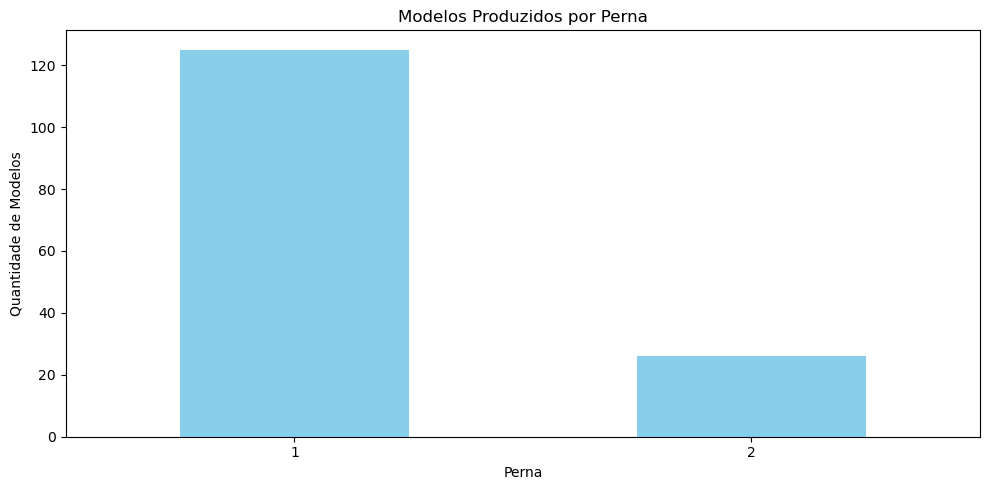

C:\Users\User\AppData\Local\Temp\ipykernel_15592\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_15592\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_15592\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_15592\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


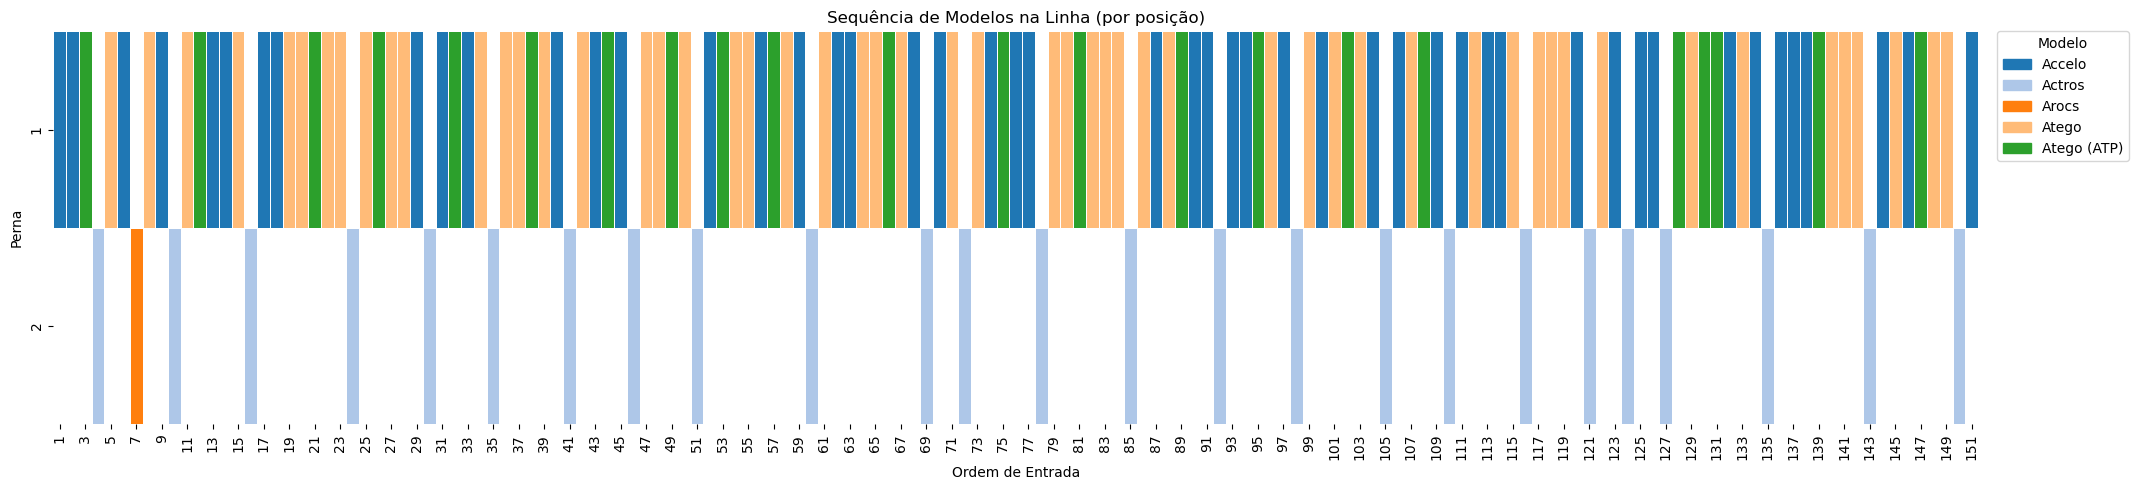

C:\Users\User\AppData\Local\Temp\ipykernel_15592\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_15592\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_ATUAL/2025-04-16/log_2025-04-16.csv
📝 PDF salvo em: logs_ATUAL/2025-04-16/resumo_simulacao.pdf


In [186]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("sequencias_entrada_linha.xlsx")

# Converte a coluna de data/hora
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'], errors='coerce')

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 16)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.dropna().unique())
# Filtra os dias a partir da data de início e pega os N primeiros
N_DIAS = 1
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:N_DIAS]


print(f"🗓️ Dias selecionados ({N_DIAS} a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_ATUAL", exist_ok=True)

# Salvando tempo por atividades
# figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
# for i, fig in enumerate(figs, start=1):
#     fig.savefig(f"logs_ATUAL/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
#     plt.close(fig)

# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_ATUAL/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # # Se já tiver o CSV salvo, pula o dia
    # if os.path.exists(nome_csv):
    #     print(f"✅ Já processado: {dia}")
    #     continue

    os.makedirs(pasta_dia, exist_ok=True)

    # --------- 🔧 AQUI ESTÁ A MUDANÇA IMPORTANTE ---------
    # Filtra dados do dia e ORDENA por Data Entrada Linha (data+hora)
    df_dia = (
        df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia]
        .copy()
        .sort_values('Data Entrada Linha', ascending=True)
    )

    # Extrai os 7 primeiros dígitos do Baumuster (removendo espaços perdidos)
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str.strip().str[:7]

    # Agora a sequência está na ordem correta (crescente por horário daquele dia)
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()
    # sequencia_modelos = ['C951104']
    # ------------------------------------------------------
    
    # (Opcional) print de conferência
    # print("Primeiros registros do dia ordenados:")
    # print(df_dia[['Data Entrada Linha', 'Baumuster', 'Baumuster_7dig']].head(10))

    # Simula
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento
    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png", dpi=300, bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png", dpi=300, bbox_inches="tight")
    plt.close(fig2)

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)

    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf, operadores)